In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

np.random.seed(42)

In [2]:
# Creating dataset
# xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))

# Generate normal (not abnormal) training observations
X = 0.3 * np.random.randn(100, 2) # create a normal distribution between 0 and 1 of the required shape
X_train = np.r_[X + 2, X - 2] # concat multiple array's of the same shape together

# Generate new normal (not abnormal) observations
X = 0.3 * np.random.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

df = pd.DataFrame(np.r_[X_train, X_test, X_outliers], columns = ['x', 'y'])
df


In [4]:
# Getting indices for each of the point
temp = df[['x', 'y']].reset_index()

# Applying cross join to calculate Euclidean distance
# Adding 0 column for cross join
temp[0] = 0
temp = pd.merge(temp, temp, how = 'outer', on = 0)
# Dropping 0 column
del temp[0]

# Calculating Euclidean distance
temp['eu_dist'] = ((temp['x_x'] - temp['x_y'])**2 + (temp['y_x'] - temp['y_y'])**2)**0.5

# Dropping zero values because they will be same point
temp = temp[temp['eu_dist'] != 0]

# Adding a rank by distance to each datapoint to get the closest K datapoint
temp["rank"] = temp.groupby("index_x")["eu_dist"].rank("min", ascending=True)

#let k = 3
k = 10
temp = temp[temp['rank'] <=k]

temp.head()

,index_x,x_x,y_x,index_y,x_y,y_y,eu_dist,rank
20,0,2.149014,1.958521,20,2.221540,2.051410,0.117849,4.0
25,0,2.149014,1.958521,25,2.097225,1.884475,0.090359,3.0
34,0,2.149014,1.958521,34,2.108491,1.806464,0.157364,9.0
38,0,2.149014,1.958521,38,2.026114,1.910298,0.132022,6.0
48,0,2.149014,1.958521,48,2.088836,2.078317,0.134061,7.0


In [5]:
# Sorting values to get the kth distance for each point
temp_2 = temp.sort_values(['index_x', 'eu_dist'], ascending = [True,False]).reset_index(drop = True)[['index_x', 'index_y','eu_dist']]

# Getting the kth value
min_indices = []

for i in np.unique(np.array(temp_2['index_x'])):
    min_indices.append(min(temp_2[temp_2['index_x'] == i].index))

kth_distance = temp_2[temp_2.index.isin(min_indices)]


kth_distance = kth_distance.rename(columns={"eu_dist": "kth_dist", "index_x": "point_label"})
del kth_distance['index_y']

kth_distance.head()

,point_label,kth_dist
0,0,0.161844
10,1,0.205434
20,2,0.143147
30,3,0.290009
40,4,0.110178


In [6]:
# Calculating reachability distance
reach_dist = pd.merge(temp_2, kth_distance, left_on = 'index_y', right_on= 'point_label', how = 'left')
del reach_dist['point_label']

reach_dist['rd'] = reach_dist[['eu_dist','kth_dist']].max(axis = 1)
del reach_dist['eu_dist']
del reach_dist['kth_dist']

reach_dist.head()

,index_x,index_y,rd
0,0,64,0.161844
1,0,34,0.163120
2,0,49,0.150285
3,0,48,0.135404
4,0,38,0.134265


In [7]:
mean_rd = pd.DataFrame(reach_dist.groupby(['index_x'])['rd'].mean()).reset_index()

mean_rd = mean_rd.rename(columns={"index_x": "point_label"})
mean_rd.head()

,point_label,rd
0,0,0.147947
1,1,0.215424
2,2,0.132591
3,3,0.259661
4,4,0.126169


In [8]:
# Getting LRD(local reachability density) for individual points
lrd_all_pts = mean_rd.copy()
lrd_all_pts['lrd'] = 1/lrd_all_pts['rd']
del lrd_all_pts['rd']

lrd_all_pts.head()

,point_label,lrd
0,0,6.759162
1,1,4.641999
2,2,7.541993
3,3,3.851181
4,4,7.925858


In [9]:
# Getting average LRD from all the neighbours
avg_lrd = pd.merge(temp_2[['index_x', 'index_y']], lrd_all_pts, left_on = 'index_y', right_on = 'point_label', how = 'left')
avg_lrd = pd.DataFrame(avg_lrd.groupby(['index_x'])['lrd'].mean()).reset_index()
avg_lrd = avg_lrd.rename({"index_x":"point_label", "lrd":"avg_lrd_neigh"}, axis = 1)

avg_lrd.head()

,point_label,avg_lrd_neigh
0,0,6.750900
1,1,4.980572
2,2,7.293563
3,3,4.488279
4,4,7.768041


In [10]:
# Calculating LOF by dividing average LRD of neighbours to the actual LRD of the point
lof = pd.merge(avg_lrd, lrd_all_pts, on = 'point_label', how = 'left')
lof['lof'] = lof['avg_lrd_neigh']/ lof['lrd']
del lof['lrd']
del lof['avg_lrd_neigh']

lof.sort_values('lof', ascending = False)[:10]

,point_label,lof
252,252,6.928729
241,241,6.026815
251,251,5.860469
250,250,5.241370
258,258,4.624574
248,248,4.594970
245,245,4.379949
256,256,4.040315
254,254,4.003144
240,240,3.935285


In [11]:
# Getting x and y coordinates for the given points
lof_df = pd.merge(df[['x', 'y']].reset_index(), lof, left_on = 'index', right_on = 'point_label', how = 'left')
del lof_df['index']
del lof_df['point_label']

lof_df.head()

,x,y,lof
0,2.149014,1.958521,0.998778
1,2.194307,2.456909,1.072937
2,1.929754,1.929759,0.967060
3,2.473764,2.230230,1.165429
4,1.859158,2.162768,0.980088


In [12]:
thresh = 2.5

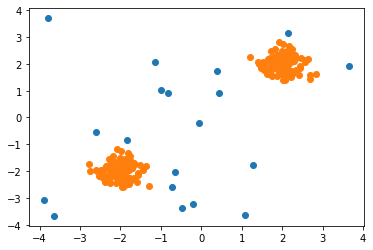

In [13]:
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(lof_df[lof_df['lof'] > thresh]['x'], lof_df[lof_df['lof'] > thresh]['y'])
plt.scatter(lof_df[lof_df['lof'] <= thresh]['x'], lof_df[lof_df['lof'] <= thresh]['y'])

plt.show()

In [14]:
# fit the model for novelty detection (novelty=True)
clf = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=0.1)
clf.fit(X_train)
# DO NOT use predict, decision_function and score_samples on X_train as this
# would give wrong results but only on new unseen data (not used in X_train),
# e.g. X_test, X_outliers or the meshgrid
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

# plot the learned frontier, the points, and the nearest vectors to the plane
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(20, 20))
plt.title("Novelty Detection with LOF")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

s = 40
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s, edgecolors='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s,
                 edgecolors='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s,
                edgecolors='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a.collections[0], b1, b2, c],
           ["learned frontier", "training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "errors novel regular: %d/40 ; errors novel abnormal: %d/40"
    % (n_error_test, n_error_outliers))
plt.show()

NameError: name 'xx' is not defined